<a href="https://colab.research.google.com/github/skywalker0803r/Ricky/blob/master/CNN_stock_v6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import seaborn as sns
import pandas_datareader.data as web
#!pip install finta
SID = '6239.tw'
df = web.DataReader(SID,'yahoo',start="2000-01-01")
df = df.iloc[:,:5]

# 載入資料

In [2]:
print(df.shape)
df.head(3)

(3663, 5)


,High,Low,Open,Close,Volume
Date,,,,,
2004-11-08,37.800098,37.251499,37.800098,37.525799,4.731376e+09
2004-11-09,38.074402,37.251499,37.525799,37.525799,4.255591e+09
2004-11-10,37.800098,37.251499,37.800098,37.525799,4.838070e+09


In [3]:
df.tail(3)

,High,Low,Open,Close,Volume
Date,,,,,
2019-09-04,77.900002,76.5,77.099998,77.400002,2390737.0
2019-09-05,79.300003,77.5,78.500000,78.900002,3876053.0
2019-09-06,82.199997,80.0,80.000000,81.500000,10030061.0


# Labeling(計算return)

In [0]:
#今天股價 = df['Close']
#昨天股價 = df['Close'].shift(1)
#df['return%'] = (今天股價/昨天股價-1)*100
#print(df['return%'].min(),df['return%'].max())
#sns.distplot(df['return%'].dropna())
#df.tail()

# Label triple_barrier

In [0]:
import numpy as np
import math
def triple_barrier(price, ub, lb, max_period):

    def end_price(s):
        return np.append(s[(s / s[0] > ub) | (s / s[0] < lb)], s[-1])[0]/s[0]
    
    r = np.array(range(max_period))
    
    def end_time(s):
        return np.append(r[(s / s[0] > ub) | (s / s[0] < lb)], max_period-1)[0]

    p = price.rolling(max_period).apply(end_price, raw=True).shift(-max_period+1)
    t = price.rolling(max_period).apply(end_time, raw=True).shift(-max_period+1)
    t = pd.Series([t.index[int(k+i)] if not math.isnan(k+i) else np.datetime64('NaT') 
                   for i, k in enumerate(t)], index=t.index).dropna()

    signal = pd.Series(0, p.index)
    signal.loc[p > ub] = 1
    signal.loc[p < lb] = -1
    ret = pd.DataFrame({'triple_barrier_profit':p, 'triple_barrier_sell_time':t, 'triple_barrier_signal':signal})

    return ret

ret = triple_barrier(df.Close, 1.07, 0.97, 20)['triple_barrier_signal']
df = df.join(ret)

In [6]:
df.tail(20)

,High,Low,Open,Close,Volume,triple_barrier_signal
Date,,,,,,
2019-08-08,75.300003,74.099998,74.500000,74.400002,2299332.0,-1
2019-08-12,74.800003,73.300003,74.199997,73.800003,1655406.0,0
2019-08-13,74.000000,73.099998,73.800003,73.400002,1558224.0,0
2019-08-14,74.500000,73.300003,74.300003,73.300003,2342668.0,0
2019-08-15,72.900002,71.800003,72.699997,71.900002,2174212.0,0
2019-08-16,72.699997,71.900002,72.000000,72.000000,2113298.0,0
2019-08-19,73.400002,72.400002,72.599998,73.000000,1476641.0,0
2019-08-20,75.199997,73.900002,74.000000,74.400002,3059700.0,0
2019-08-21,74.900002,74.000000,74.800003,74.000000,1957183.0,0


(33.41837255218191, 42.240241987918196)

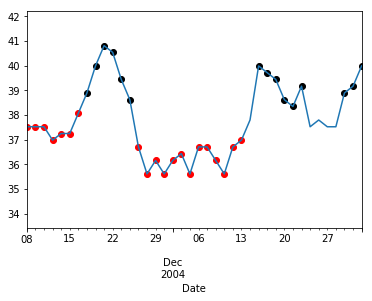

In [7]:
import matplotlib.pyplot as plt
buy = df[df['triple_barrier_signal']==1]['Close']
sell = df[df['triple_barrier_signal']==-1]['Close']
df['Close'][0:40].plot()#後20筆是前20筆的驗證
plt.scatter(buy.index,buy.values,color='red')
plt.scatter(sell.index,sell.values,color='black')
lb = df['Close'][0:40].mean() - 3*df['Close'][0:40].std()
ub = df['Close'][0:40].mean() + 3*df['Close'][0:40].std()
plt.ylim(lb,ub)

# 建立ohlcv

In [0]:
from finta import TA
ohlcv = df[['Open','High','Low','Close','Volume']]
ohlcv.columns = ['open','high','low','close','volume']

# 計算技術指標RSI

count    3660.000000
mean       51.328173
std        15.432847
min         0.000000
25%        41.001507
50%        51.380541
75%        61.912457
max        95.170059
Name: RSI, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI
Date,,,,,,,
2019-09-02,76.500000,75.400002,76.000000,76.300003,1867471.0,0,63.083007
2019-09-03,78.000000,76.199997,76.500000,77.000000,3564478.0,0,67.290735
2019-09-04,77.900002,76.500000,77.099998,77.400002,2390737.0,0,69.577051
2019-09-05,79.300003,77.500000,78.500000,78.900002,3876053.0,0,76.641619
2019-09-06,82.199997,80.000000,80.000000,81.500000,10030061.0,0,84.049434


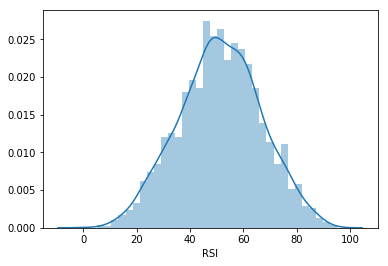

In [9]:
df['RSI'] = TA.RSI(ohlcv)
print(df['RSI'].describe())
sns.distplot(df['RSI'].dropna())
df.tail()

# 計算威廉指標

count    3650.000000
mean      -47.995500
std        29.252325
min      -100.000000
25%       -73.799801
50%       -45.945800
75%       -21.999969
max        -0.000000
Name: Williams %R, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R
Date,,,,,,,,
2019-09-02,76.500000,75.400002,76.000000,76.300003,1867471.0,0,63.083007,-4.255257
2019-09-03,78.000000,76.199997,76.500000,77.000000,3564478.0,0,67.290735,-16.129040
2019-09-04,77.900002,76.500000,77.099998,77.400002,2390737.0,0,69.577051,-9.677400
2019-09-05,79.300003,77.500000,78.500000,78.900002,3876053.0,0,76.641619,-5.405425
2019-09-06,82.199997,80.000000,80.000000,81.500000,10030061.0,0,84.049434,-7.142829


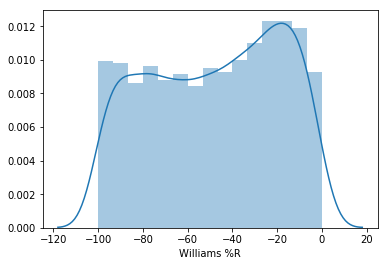

In [10]:
df['Williams %R'] = TA.WILLIAMS(ohlcv)
print(df['Williams %R'].describe())
sns.distplot(df['Williams %R'].dropna())
df.tail()

# SMA

count    3623.000000
mean       70.844162
std        17.395234
min        37.668158
25%        55.109574
50%        69.175610
75%        88.028161
max       102.990583
Name: SMA, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA
Date,,,,,,,,,
2019-09-02,76.500000,75.400002,76.000000,76.300003,1867471.0,0,63.083007,-4.255257,77.668293
2019-09-03,78.000000,76.199997,76.500000,77.000000,3564478.0,0,67.290735,-16.129040,77.646342
2019-09-04,77.900002,76.500000,77.099998,77.400002,2390737.0,0,69.577051,-9.677400,77.631708
2019-09-05,79.300003,77.500000,78.500000,78.900002,3876053.0,0,76.641619,-5.405425,77.678049
2019-09-06,82.199997,80.000000,80.000000,81.500000,10030061.0,0,84.049434,-7.142829,77.802439


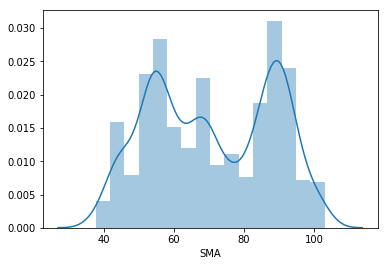

In [11]:
df['SMA'] = TA.SMA(ohlcv)
print(df['SMA'].describe())
sns.distplot(df['SMA'].dropna())
df.tail()

# EMA

count    3663.000000
mean       70.651154
std        17.795778
min        36.367041
25%        55.083184
50%        69.427214
75%        87.623008
max       107.362114
Name: EMA, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA
Date,,,,,,,,,,
2019-09-02,76.500000,75.400002,76.000000,76.300003,1867471.0,0,63.083007,-4.255257,77.668293,74.705958
2019-09-03,78.000000,76.199997,76.500000,77.000000,3564478.0,0,67.290735,-16.129040,77.646342,75.164767
2019-09-04,77.900002,76.500000,77.099998,77.400002,2390737.0,0,69.577051,-9.677400,77.631708,75.611814
2019-09-05,79.300003,77.500000,78.500000,78.900002,3876053.0,0,76.641619,-5.405425,77.678049,76.269451
2019-09-06,82.199997,80.000000,80.000000,81.500000,10030061.0,0,84.049434,-7.142829,77.802439,77.315561


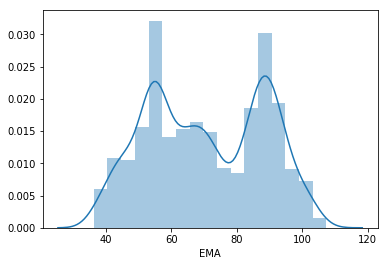

In [12]:
df['EMA'] = TA.EMA(ohlcv)
print(df['EMA'].describe())
sns.distplot(df['EMA'])
df.tail()

# WMA

/usr/local/lib/python3.6/dist-packages/finta/finta.py:263: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  wma = close_.apply(linear(weights))


count    3655.000000
mean       70.708653
std        17.817643
min        36.007111
25%        55.116667
50%        69.533880
75%        87.440193
max       109.591624
Name: WMA, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA
Date,,,,,,,,,,,
2019-09-02,76.500000,75.400002,76.000000,76.300003,1867471.0,0,63.083007,-4.255257,77.668293,74.705958,74.382223
2019-09-03,78.000000,76.199997,76.500000,77.000000,3564478.0,0,67.290735,-16.129040,77.646342,75.164767,74.471112
2019-09-04,77.900002,76.500000,77.099998,77.400002,2390737.0,0,69.577051,-9.677400,77.631708,75.611814,74.715556
2019-09-05,79.300003,77.500000,78.500000,78.900002,3876053.0,0,76.641619,-5.405425,77.678049,76.269451,74.891111
2019-09-06,82.199997,80.000000,80.000000,81.500000,10030061.0,0,84.049434,-7.142829,77.802439,77.315561,75.148890


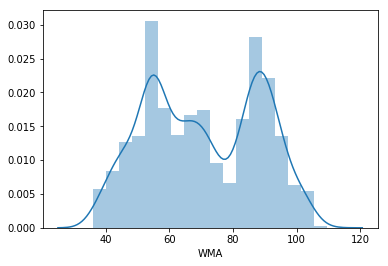

In [13]:
df['WMA'] = TA.WMA(ohlcv)
print(df['WMA'].describe())
sns.distplot(df['WMA'].dropna())
df.tail()

# HMA

/usr/local/lib/python3.6/dist-packages/finta/finta.py:263: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  wma = close_.apply(linear(weights))
/usr/local/lib/python3.6/dist-packages/finta/finta.py:285: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  ohlc['deltawma'] = 2 * wmaf - wmas


count    3660.000000
mean       70.698583
std        17.868879
min        34.948040
25%        55.102011
50%        69.585000
75%        87.362499
max       112.862100
Name: HMA, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA
Date,,,,,,,,,,,,
2019-09-02,76.500000,75.400002,76.000000,76.300003,1867471.0,0,63.083007,-4.255257,77.668293,74.705958,74.382223,74.340002
2019-09-03,78.000000,76.199997,76.500000,77.000000,3564478.0,0,67.290735,-16.129040,77.646342,75.164767,74.471112,75.050001
2019-09-04,77.900002,76.500000,77.099998,77.400002,2390737.0,0,69.577051,-9.677400,77.631708,75.611814,74.715556,76.070000
2019-09-05,79.300003,77.500000,78.500000,78.900002,3876053.0,0,76.641619,-5.405425,77.678049,76.269451,74.891111,76.990002
2019-09-06,82.199997,80.000000,80.000000,81.500000,10030061.0,0,84.049434,-7.142829,77.802439,77.315561,75.148890,77.950001


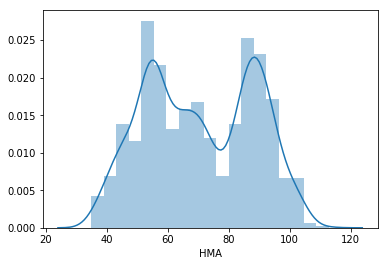

In [14]:
df['HMA'] = TA.HMA(ohlcv)
print(df['HMA'].describe())
sns.distplot(df['HMA'].dropna())
df.tail()

# TEMA

count    3663.000000
mean       70.693028
std        17.926927
min        34.153027
25%        55.028586
50%        69.632817
75%        87.256648
max       112.774093
Name: TEMA, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA
Date,,,,,,,,,,,,,
2019-09-02,76.500000,75.400002,76.000000,76.300003,1867471.0,0,63.083007,-4.255257,77.668293,74.705958,74.382223,74.340002,75.616652
2019-09-03,78.000000,76.199997,76.500000,77.000000,3564478.0,0,67.290735,-16.129040,77.646342,75.164767,74.471112,75.050001,76.538654
2019-09-04,77.900002,76.500000,77.099998,77.400002,2390737.0,0,69.577051,-9.677400,77.631708,75.611814,74.715556,76.070000,77.283662
2019-09-05,79.300003,77.500000,78.500000,78.900002,3876053.0,0,76.641619,-5.405425,77.678049,76.269451,74.891111,76.990002,78.439899
2019-09-06,82.199997,80.000000,80.000000,81.500000,10030061.0,0,84.049434,-7.142829,77.802439,77.315561,75.148890,77.950001,80.382917


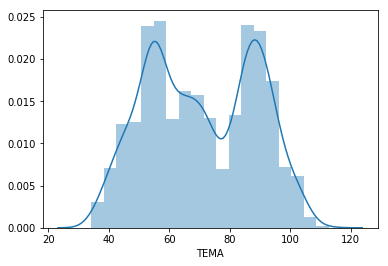

In [15]:
df['TEMA'] = TA.TEMA(ohlcv)
print(df['TEMA'].describe())
sns.distplot(df['TEMA'].dropna())
df.tail()

# CCI

count    3662.000000
mean        8.723562
std        86.020353
min      -258.425661
25%       -59.213612
50%        13.738972
75%        75.324421
max       224.146238
Name: CCI, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI
Date,,,,,,,,,,,,,,
2019-09-02,76.500000,75.400002,76.000000,76.300003,1867471.0,0,63.083007,-4.255257,77.668293,74.705958,74.382223,74.340002,75.616652,80.970279
2019-09-03,78.000000,76.199997,76.500000,77.000000,3564478.0,0,67.290735,-16.129040,77.646342,75.164767,74.471112,75.050001,76.538654,142.663663
2019-09-04,77.900002,76.500000,77.099998,77.400002,2390737.0,0,69.577051,-9.677400,77.631708,75.611814,74.715556,76.070000,77.283662,145.635444
2019-09-05,79.300003,77.500000,78.500000,78.900002,3876053.0,0,76.641619,-5.405425,77.678049,76.269451,74.891111,76.990002,78.439899,163.097672
2019-09-06,82.199997,80.000000,80.000000,81.500000,10030061.0,0,84.049434,-7.142829,77.802439,77.315561,75.148890,77.950001,80.382917,191.259805


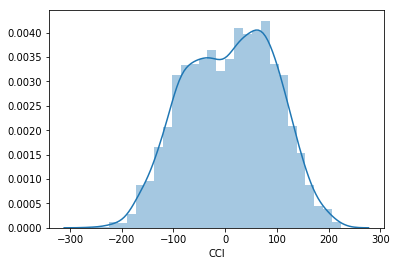

In [16]:
df['CCI'] = TA.CCI(ohlcv)
print(df['CCI'].describe())
sns.distplot(df['CCI'].dropna())
df.tail()

# CMO

count    3654.000000
mean        3.019402
std        39.313091
min      -100.000000
25%       -24.264453
50%         4.201695
75%        31.383903
max       100.000000
Name: CMO, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO
Date,,,,,,,,,,,,,,,
2019-09-02,76.500000,75.400002,76.000000,76.300003,1867471.0,0,63.083007,-4.255257,77.668293,74.705958,74.382223,74.340002,75.616652,80.970279,46.478876
2019-09-03,78.000000,76.199997,76.500000,77.000000,3564478.0,0,67.290735,-16.129040,77.646342,75.164767,74.471112,75.050001,76.538654,142.663663,40.624966
2019-09-04,77.900002,76.500000,77.099998,77.400002,2390737.0,0,69.577051,-9.677400,77.631708,75.611814,74.715556,76.070000,77.283662,145.635444,53.125011
2019-09-05,79.300003,77.500000,78.500000,78.900002,3876053.0,0,76.641619,-5.405425,77.678049,76.269451,74.891111,76.990002,78.439899,163.097672,57.746470
2019-09-06,82.199997,80.000000,80.000000,81.500000,10030061.0,0,84.049434,-7.142829,77.802439,77.315561,75.148890,77.950001,80.382917,191.259805,68.085112


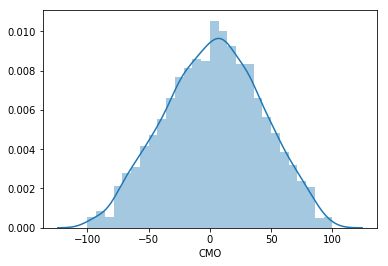

In [17]:
df['CMO'] = TA.CMO(ohlcv)
print(df['CMO'].describe())
sns.distplot(df['CMO'].dropna())
df.tail()

# MACD

count    3663.000000
mean       -0.000660
std         0.498664
min        -2.334417
25%        -0.276677
50%         0.005484
75%         0.292106
max         1.651282
Name: MACD, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD
Date,,,,,,,,,,,,,,,,
2019-09-02,76.500000,75.400002,76.000000,76.300003,1867471.0,0,63.083007,-4.255257,77.668293,74.705958,74.382223,74.340002,75.616652,80.970279,46.478876,0.306814
2019-09-03,78.000000,76.199997,76.500000,77.000000,3564478.0,0,67.290735,-16.129040,77.646342,75.164767,74.471112,75.050001,76.538654,142.663663,40.624966,0.443041
2019-09-04,77.900002,76.500000,77.099998,77.400002,2390737.0,0,69.577051,-9.677400,77.631708,75.611814,74.715556,76.070000,77.283662,145.635444,53.125011,0.540970
2019-09-05,79.300003,77.500000,78.500000,78.900002,3876053.0,0,76.641619,-5.405425,77.678049,76.269451,74.891111,76.990002,78.439899,163.097672,57.746470,0.678727
2019-09-06,82.199997,80.000000,80.000000,81.500000,10030061.0,0,84.049434,-7.142829,77.802439,77.315561,75.148890,77.950001,80.382917,191.259805,68.085112,0.902879


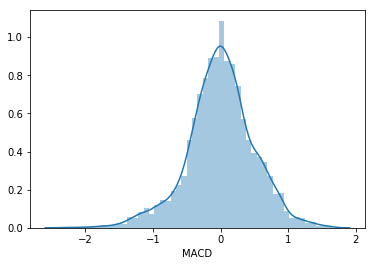

In [18]:
df['MACD'] = TA.MACD(ohlcv)['MACD'] - TA.MACD(ohlcv)['SIGNAL']
print(df['MACD'].describe())
sns.distplot(df['MACD'].dropna())
df.tail()

# PPO

count    3663.000000
mean       -0.000886
std         0.726917
min        -3.420147
25%        -0.423215
50%        -0.008885
75%         0.427415
max         2.757767
Name: PPO, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO
Date,,,,,,,,,,,,,,,,,
2019-09-02,76.500000,75.400002,76.000000,76.300003,1867471.0,0,63.083007,-4.255257,77.668293,74.705958,74.382223,74.340002,75.616652,80.970279,46.478876,0.306814,0.398785
2019-09-03,78.000000,76.199997,76.500000,77.000000,3564478.0,0,67.290735,-16.129040,77.646342,75.164767,74.471112,75.050001,76.538654,142.663663,40.624966,0.443041,0.580990
2019-09-04,77.900002,76.500000,77.099998,77.400002,2390737.0,0,69.577051,-9.677400,77.631708,75.611814,74.715556,76.070000,77.283662,145.635444,53.125011,0.540970,0.711661
2019-09-05,79.300003,77.500000,78.500000,78.900002,3876053.0,0,76.641619,-5.405425,77.678049,76.269451,74.891111,76.990002,78.439899,163.097672,57.746470,0.678727,0.893767
2019-09-06,82.199997,80.000000,80.000000,81.500000,10030061.0,0,84.049434,-7.142829,77.802439,77.315561,75.148890,77.950001,80.382917,191.259805,68.085112,0.902879,1.186059


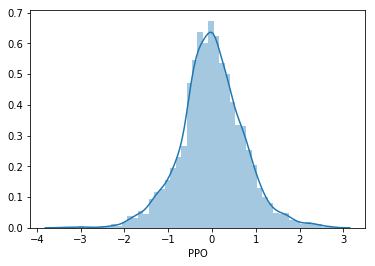

In [19]:
df['PPO'] = TA.PPO(ohlcv)['PPO'] - TA.PPO(ohlcv)['SIGNAL']
print(df['PPO'].describe())
sns.distplot(df['PPO'].dropna())
df.tail()

# ROC

count    3651.000000
mean        0.510732
std         7.526397
min       -34.117499
25%        -3.358220
50%         0.538350
75%         4.824581
max        47.699599
Name: ROC, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC
Date,,,,,,,,,,,,,,,,,,
2019-09-02,76.500000,75.400002,76.000000,76.300003,1867471.0,0,63.083007,-4.255257,77.668293,74.705958,74.382223,74.340002,75.616652,80.970279,46.478876,0.306814,0.398785,4.092769
2019-09-03,78.000000,76.199997,76.500000,77.000000,3564478.0,0,67.290735,-16.129040,77.646342,75.164767,74.471112,75.050001,76.538654,142.663663,40.624966,0.443041,0.580990,7.093183
2019-09-04,77.900002,76.500000,77.099998,77.400002,2390737.0,0,69.577051,-9.677400,77.631708,75.611814,74.715556,76.070000,77.283662,145.635444,53.125011,0.540970,0.711661,7.500002
2019-09-05,79.300003,77.500000,78.500000,78.900002,3876053.0,0,76.641619,-5.405425,77.678049,76.269451,74.891111,76.990002,78.439899,163.097672,57.746470,0.678727,0.893767,8.082194
2019-09-06,82.199997,80.000000,80.000000,81.500000,10030061.0,0,84.049434,-7.142829,77.802439,77.315561,75.148890,77.950001,80.382917,191.259805,68.085112,0.902879,1.186059,9.543009


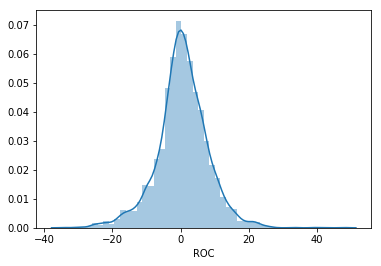

In [20]:
df['ROC'] = TA.ROC(ohlcv)
print(df['ROC'].describe())
sns.distplot(df['ROC'].dropna())
df.tail()

# CMFI

count    3.654000e+03
mean    -2.458336e+11
std      2.004651e+11
min     -3.861853e+11
25%     -2.978471e+11
50%     -2.971676e+11
75%     -2.969797e+11
max      6.943551e+11
Name: CFI, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI
Date,,,,,,,,,,,,,,,,,,,
2019-09-02,76.500000,75.400002,76.000000,76.300003,1867471.0,0,63.083007,-4.255257,77.668293,74.705958,74.382223,74.340002,75.616652,80.970279,46.478876,0.306814,0.398785,4.092769,-2.969975e+11
2019-09-03,78.000000,76.199997,76.500000,77.000000,3564478.0,0,67.290735,-16.129040,77.646342,75.164767,74.471112,75.050001,76.538654,142.663663,40.624966,0.443041,0.580990,7.093183,-2.969964e+11
2019-09-04,77.900002,76.500000,77.099998,77.400002,2390737.0,0,69.577051,-9.677400,77.631708,75.611814,74.715556,76.070000,77.283662,145.635444,53.125011,0.540970,0.711661,7.500002,-2.969953e+11
2019-09-05,79.300003,77.500000,78.500000,78.900002,3876053.0,0,76.641619,-5.405425,77.678049,76.269451,74.891111,76.990002,78.439899,163.097672,57.746470,0.678727,0.893767,8.082194,-2.969933e+11
2019-09-06,82.199997,80.000000,80.000000,81.500000,10030061.0,0,84.049434,-7.142829,77.802439,77.315561,75.148890,77.950001,80.382917,191.259805,68.085112,0.902879,1.186059,9.543009,-2.969869e+11


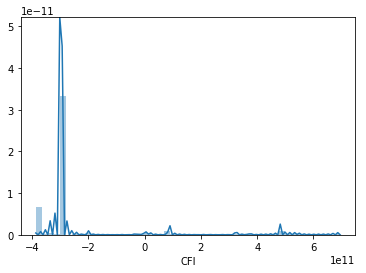

In [21]:
df['CFI'] = TA.CFI(ohlcv)
print(df['CFI'].describe())
sns.distplot(df['CFI'].dropna())
df.tail()

# DMI

/usr/local/lib/python3.6/dist-packages/finta/finta.py:792: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  ohlc["up_move"] = ohlc["high"].diff()
/usr/local/lib/python3.6/dist-packages/finta/finta.py:793: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  ohlc["down_move"] = -ohlc["low"].diff()
/usr/local/lib/python3.6/dist-packages/finta/finta.py:809: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

count    3580.000000
mean        1.438576
std        21.467703
min       -96.489363
25%       -10.122650
50%         1.785808
75%        13.080382
max        94.141454
Name: DMI, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI,DMI
Date,,,,,,,,,,,,,,,,,,,,
2019-09-02,76.500000,75.400002,76.000000,76.300003,1867471.0,0,63.083007,-4.255257,77.668293,74.705958,74.382223,74.340002,75.616652,80.970279,46.478876,0.306814,0.398785,4.092769,-2.969975e+11,13.444991
2019-09-03,78.000000,76.199997,76.500000,77.000000,3564478.0,0,67.290735,-16.129040,77.646342,75.164767,74.471112,75.050001,76.538654,142.663663,40.624966,0.443041,0.580990,7.093183,-2.969964e+11,24.227179
2019-09-04,77.900002,76.500000,77.099998,77.400002,2390737.0,0,69.577051,-9.677400,77.631708,75.611814,74.715556,76.070000,77.283662,145.635444,53.125011,0.540970,0.711661,7.500002,-2.969953e+11,20.996888
2019-09-05,79.300003,77.500000,78.500000,78.900002,3876053.0,0,76.641619,-5.405425,77.678049,76.269451,74.891111,76.990002,78.439899,163.097672,57.746470,0.678727,0.893767,8.082194,-2.969933e+11,29.986792
2019-09-06,82.199997,80.000000,80.000000,81.500000,10030061.0,0,84.049434,-7.142829,77.802439,77.315561,75.148890,77.950001,80.382917,191.259805,68.085112,0.902879,1.186059,9.543009,-2.969869e+11,50.137206


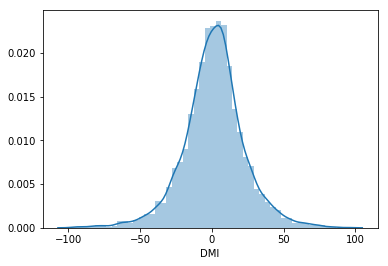

In [22]:
df['DMI'] = TA.DMI(ohlcv)['DI+'] - TA.DMI(ohlcv)['DI-']
print(df['DMI'].describe())
sns.distplot(df['DMI'].dropna())
df.tail()

# SAR

count    3663.000000
mean       70.540760
std        18.450801
min        31.861500
25%        54.478734
50%        69.500000
75%        87.715896
max       116.352997
Name: SAR, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI,DMI,SAR
Date,,,,,,,,,,,,,,,,,,,,,
2019-09-02,76.500000,75.400002,76.000000,76.300003,1867471.0,0,63.083007,-4.255257,77.668293,74.705958,74.382223,74.340002,75.616652,80.970279,46.478876,0.306814,0.398785,4.092769,-2.969975e+11,13.444991,71.800003
2019-09-03,78.000000,76.199997,76.500000,77.000000,3564478.0,0,67.290735,-16.129040,77.646342,75.164767,74.471112,75.050001,76.538654,142.663663,40.624966,0.443041,0.580990,7.093183,-2.969964e+11,24.227179,71.800003
2019-09-04,77.900002,76.500000,77.099998,77.400002,2390737.0,0,69.577051,-9.677400,77.631708,75.611814,74.715556,76.070000,77.283662,145.635444,53.125011,0.540970,0.711661,7.500002,-2.969953e+11,20.996888,72.048003
2019-09-05,79.300003,77.500000,78.500000,78.900002,3876053.0,0,76.641619,-5.405425,77.678049,76.269451,74.891111,76.990002,78.439899,163.097672,57.746470,0.678727,0.893767,8.082194,-2.969933e+11,29.986792,72.286083
2019-09-06,82.199997,80.000000,80.000000,81.500000,10030061.0,0,84.049434,-7.142829,77.802439,77.315561,75.148890,77.950001,80.382917,191.259805,68.085112,0.902879,1.186059,9.543009,-2.969869e+11,50.137206,72.706918


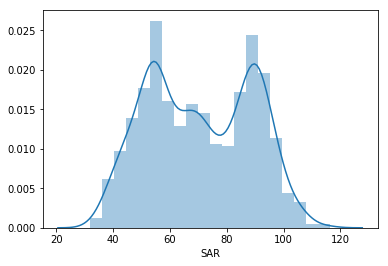

In [23]:
df['SAR'] = TA.SAR(ohlcv)
print(df['SAR'].describe())
sns.distplot(df['SAR'].dropna())
df.tail()

# columns選取

In [24]:
print(df.shape)
df = df.dropna(axis=0)#刪除有缺失的row,會缺失主要因為用時間rolling計算技術指標導致,正常的
features = df.columns[-15:].tolist() #取15個剛剛建立的技術指標當特徵
y_name = 'triple_barrier_signal' #當作labels
df = df[features+[y_name]]
print(df.shape)
df.tail()

(3663, 21)
(3580, 16)


,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI,DMI,SAR,triple_barrier_signal
Date,,,,,,,,,,,,,,,,
2019-09-02,63.083007,-4.255257,77.668293,74.705958,74.382223,74.340002,75.616652,80.970279,46.478876,0.306814,0.398785,4.092769,-2.969975e+11,13.444991,71.800003,0
2019-09-03,67.290735,-16.129040,77.646342,75.164767,74.471112,75.050001,76.538654,142.663663,40.624966,0.443041,0.580990,7.093183,-2.969964e+11,24.227179,71.800003,0
2019-09-04,69.577051,-9.677400,77.631708,75.611814,74.715556,76.070000,77.283662,145.635444,53.125011,0.540970,0.711661,7.500002,-2.969953e+11,20.996888,72.048003,0
2019-09-05,76.641619,-5.405425,77.678049,76.269451,74.891111,76.990002,78.439899,163.097672,57.746470,0.678727,0.893767,8.082194,-2.969933e+11,29.986792,72.286083,0
2019-09-06,84.049434,-7.142829,77.802439,77.315561,75.148890,77.950001,80.382917,191.259805,68.085112,0.902879,1.186059,9.543009,-2.969869e+11,50.137206,72.706918,0


# 相關性分析

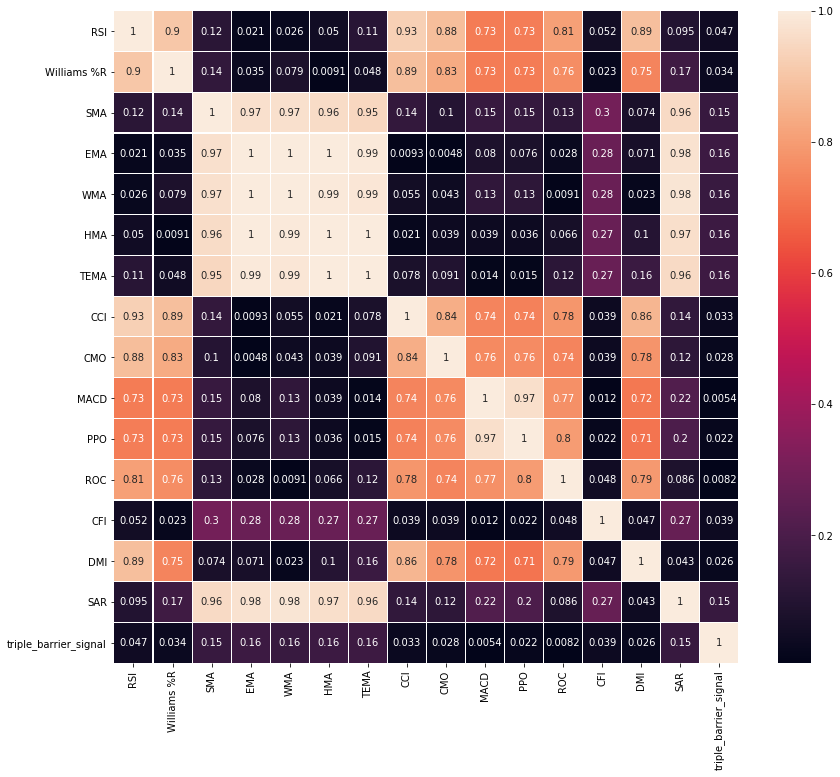

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(14,12))
sns.heatmap(abs(df.corr()),annot=True,linewidths=0.1)

# features scaling

In [26]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
df_minmax = min_max_scaler.fit_transform(df)#縮放到0-1之間
df_minmax = pd.DataFrame(df_minmax,
                         index = df.index,
                         columns = df.columns)#轉回dataframe格式
df_minmax[y_name] = df[y_name]#y不用MinMaxScaler
df_minmax.tail()

,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI,DMI,SAR,triple_barrier_signal
Date,,,,,,,,,,,,,,,,
2019-09-02,0.638931,0.957447,0.592258,0.536053,0.520761,0.505582,0.527386,0.703306,0.732394,0.662677,0.618159,0.467021,0.082540,0.576687,0.472693,0
2019-09-03,0.686280,0.838710,0.591904,0.542571,0.521971,0.514695,0.539113,0.831149,0.703125,0.696856,0.647652,0.503693,0.082541,0.633248,0.472693,0
2019-09-04,0.712007,0.903226,0.591669,0.548922,0.525298,0.527786,0.548589,0.837308,0.765625,0.721426,0.668803,0.508665,0.082542,0.616303,0.475628,0
2019-09-05,0.791503,0.945946,0.592415,0.558265,0.527688,0.539594,0.563295,0.873493,0.788732,0.755989,0.698280,0.515781,0.082544,0.663461,0.478446,0
2019-09-06,0.874862,0.928572,0.594418,0.573127,0.531196,0.551915,0.588009,0.931852,0.840426,0.812228,0.745592,0.533635,0.082550,0.769165,0.483426,0


In [27]:
df = df_minmax
print('特徵縮放完成!')

特徵縮放完成!


# Xs ,ys prepare

In [28]:
from tqdm import tqdm
import numpy as np

#定義觀察天數,起始index(0),結束index(資料筆數-觀察天數)
days = 15
b_index = 0
f_index = len(df)-days

#特徵欄位
features = df.drop(y_name,axis=1).columns.tolist()

#待存放序列
Xs = []
ys = []
indexs = []

'''
若資料筆數100,days=15天,f_index=85,i只會跑到84,i+days=99,features只會跑到98天.
若資料筆數100,days=15天,f_index=85+1,i會跑到85,i+days=100,features會跑到99天.
'''
for i in tqdm(range(b_index ,f_index+1 ,1)):#每次i都會遞增1
  X = df.iloc[i:i+days,:][features] #ex:0...14(不含15)之features
  y = df.iloc[i+days-1:i+days,:][y_name]#ex:14,y_name
  X = np.array(X) # to np_array
  Xs.append(X) #加入一筆X
  ys.append(y) #加入一筆y
  indexs.append((df.iloc[[i]].index,
                 df.iloc[[i+days-1]].index)) #加入資料日期
#轉換成np_array
Xs = np.array(Xs)
ys = np.array(ys)
print('準備完成')

100%|██████████| 3566/3566 [00:07<00:00, 473.82it/s]


準備完成


# check

In [29]:
print('資料筆數:',len(Xs))
print('第一筆的index開始和結束:{}-{}'.format(indexs[0][0].date[0],indexs[0][1].date[0]))
print('最後一筆的index開始和結束:{}-{}'.format(indexs[-1][0].date[0],indexs[-1][1].date[0]))

資料筆數: 3566
第一筆的index開始和結束:2005-03-03-2005-03-23
最後一筆的index開始和結束:2019-08-16-2019-09-06


# Reshape X

(圖片數量,長,寬,1張)

In [30]:
print(Xs.shape)
Xs = Xs.reshape(-1,days,len(features),1)
print(Xs.shape)

(3566, 15, 15)
(3566, 15, 15, 1)


# One hot encoding of label

原始y代表漲幅

In [31]:
print(ys.shape)
print(ys[:5])

from keras.utils.np_utils import to_categorical
ys = to_categorical(ys, num_classes = 3)
print(ys.shape)
print(ys[:5])

(3566, 1)
[[-1]
 [-1]
 [-1]
 [-1]
 [ 0]]


Using TensorFlow backend.


(3566, 3)
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]


# Visualization

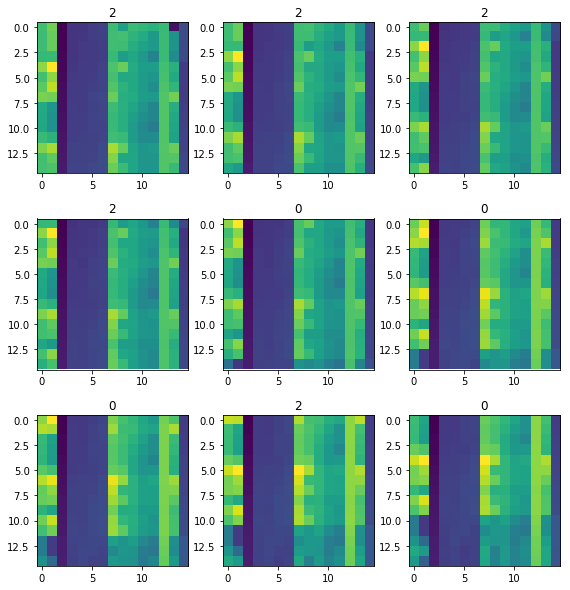

In [32]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
Xs_v = Xs.reshape(-1,Xs.shape[1],Xs.shape[2])
plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace =0, hspace =0.3)
for i in range(0,9):
    plt.subplot(330 + (i+1))
    plt.imshow(Xs_v[i])
    plt.title(np.argmax(ys[i]))

# Split training and validation sets

In [33]:
X_test = Xs[-40:] #最後40天features當作test資料
X_train,y_train = Xs[:-40],ys[:-40] #其他當作訓練
print(X_train.shape,y_train.shape,X_test.shape)

(3526, 15, 15, 1) (3526, 3) (40, 15, 15, 1)


In [34]:
from sklearn.model_selection import train_test_split
xtrain, xval, ytrain, yval = train_test_split(X_train,
                                              y_train, 
                                              test_size=0.2,
                                              random_state=42,
                                              shuffle=True,#是否洗牌
                                              stratify=None #是否根據y欄位做分層取樣
                                             )
print(xtrain.shape, ytrain.shape, xval.shape, yval.shape)

(2820, 15, 15, 1) (2820, 3) (706, 15, 15, 1) (706, 3)


# 看一下樣本的label分布情況是否平均(待解決)

0:Hold,1:Buy,2:Sell

In [35]:
pd.Series([np.argmax(i) for i in ys]).value_counts()

2    1975
1    1000
0     591
dtype: int64

In [36]:
pd.Series([np.argmax(i) for i in ytrain]).value_counts()

2    1583
1     772
0     465
dtype: int64

In [37]:
pd.Series([np.argmax(i) for i in yval]).value_counts()

2    380
1    219
0    107
dtype: int64

# CNN

In [0]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Lambda, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPool2D, AvgPool2D
from keras.optimizers import Adam #做梯度下降的一種優化方法
from keras.callbacks import ReduceLROnPlateau , EarlyStopping #減少學習速率 on Plateau

In [39]:
model = Sequential()

nclasses = 3 

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(15,15,1)))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu',))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(nclasses, activation='softmax'))
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 15, 15, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               401536    


In [40]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# 優化器

In [0]:
#1
lr_reduction = ReduceLROnPlateau(monitor = 'val_acc', 
                                 factor=0.5, 
                                 patience = 3, 
                                 verbose = 1, 
                                 min_lr = 0.00001)

#2
es = EarlyStopping(monitor='val_acc',#驗證集acc
                   min_delta=0, 
                   patience=20,  
                   mode='max',
                   restore_best_weights=False)#恢復最佳權重

# fit

In [42]:
history = model.fit(xtrain,ytrain,
                    batch_size = 128,
                    epochs = 256,
                    validation_data=(xval,yval),
                    verbose=1,callbacks=[es])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 2820 samples, validate on 706 samples
Epoch 1/256
2820/2820 [==============================] - 3s 1ms/step - loss: 0.9909 - acc: 0.5493 - val_loss: 0.9832 - val_acc: 0.5382
Epoch 2/256
2820/2820 [==============================] - 0s 56us/step - loss: 0.9749 - acc: 0.5582 - val_loss: 0.9716 - val_acc: 0.5382
Epoch 3/256
2820/2820 [==============================] - 0s 51us/step - loss: 0.9714 - acc: 0.5603 - val_loss: 0.9858 - val_acc: 0.5382
Epoch 4/256
2820/2820 [==============================] - 0s 56us/step - loss: 0.9710 - acc: 0.5592 - val_loss: 0.9662 - val_acc: 0.5382
Epoch 5/256
2820/2820 [==============================] - 0s 50us/step - loss: 0.9655 - acc: 0.5606 - val_loss: 0.9601 - val_acc: 0.5397
Epoch 6/256
2820/2820 [==============================] - 0s 47us/step - loss: 0.9544 - acc: 0.5617 - val_loss: 0.9585 - val_acc: 0.5382
Epoch 7/256
2820/2820 [=====================

# 訓練過程評估

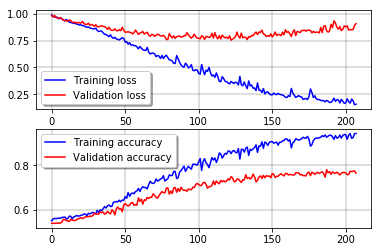

In [43]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
ax[0].grid(color='black', linestyle='-', linewidth=0.25)
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax[1].grid(color='black', linestyle='-', linewidth=0.25)
legend = ax[1].legend(loc='best', shadow=True)

# 混淆矩陣

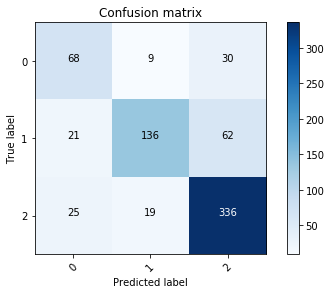

In [44]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#預測的y
ypred_onehot = model.predict(xval)
#轉換預測的y: [0 0 1 0 0 ...] --> 2
ypred = np.argmax(ypred_onehot,axis=1)
#轉換真實的y
ytrue = np.argmax(yval,axis=1)
#計算 confusion matrix
confusion_mtx = confusion_matrix(ytrue, ypred)
#畫出 confusion matrix
plot_confusion_matrix(confusion_mtx, classes=range(nclasses))

# 分類report

轉換預測結果

In [45]:
y_pred = model.predict(xval)
y_pred = [np.argmax(i) for i in y_pred]
y_pred = to_categorical(y_pred, num_classes = 3)
print(y_pred[:5])

[[0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


真實y值

In [46]:
print(yval[:5])

[[0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


# 分類報告

In [47]:
from sklearn.metrics import classification_report 
target_names = ['Hold','BUY','SELL']
print(classification_report(yval,y_pred,target_names=target_names))

              precision    recall  f1-score   support

        Hold       0.60      0.64      0.62       107
         BUY       0.83      0.62      0.71       219
        SELL       0.79      0.88      0.83       380

   micro avg       0.76      0.76      0.76       706
   macro avg       0.74      0.71      0.72       706
weighted avg       0.77      0.76      0.76       706
 samples avg       0.76      0.76      0.76       706



# plot error

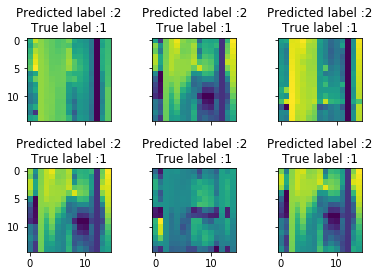

In [48]:
errors = (ypred - ytrue != 0)

ypred_er = ypred_onehot[errors]
ypred_classes_er = ypred[errors]
ytrue_er = ytrue[errors]
xval_er = xval[errors]

def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True)
    plt.subplots_adjust(wspace =0.5, hspace =0.5)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((days,len(features))))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1
            
# 錯誤預測的概率
ypred_er_prob = np.max(ypred_er,axis=1)

# Predicted probabilities of the true values in the error set
true_prob_er = np.diagonal(np.take(ypred_er, ytrue_er, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_er = ypred_er_prob - true_prob_er

# Sorted list of the delta prob errors
sorted_delta_er = np.argsort(delta_pred_true_er)

# Top 6 errors. You can change the range to see other images
most_important_er = sorted_delta_er[-6:]

# Show the top 6 errors
display_errors(most_important_er, xval_er, ypred_classes_er, ytrue_er)

## 預測最後40筆

In [49]:
answer = model.predict(X_test)
answer = [ np.argmax(i) for i in answer]
print(len(answer))

40


# 0~20筆

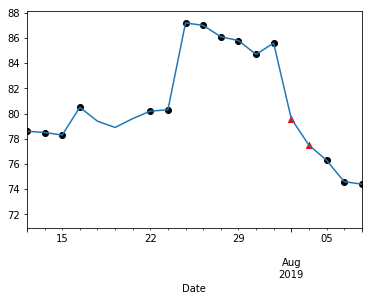

In [50]:
INDEX60 = df[-60:].index
C = web.DataReader(SID,'yahoo',start="2000-01-01")[['Close']]
C = C.loc[INDEX60,:]
C['SIGNAL'] = [np.nan for _ in range(20)] + answer #20個NAN+預測答案
buy = C[C['SIGNAL']==1]['Close']
sell = C[C['SIGNAL']==2]['Close']
C['Close'][20:40].plot()
plt.scatter(buy.index,buy.values,color='red',marker="^")
plt.scatter(sell.index,sell.values,color='black')

# 20~40筆

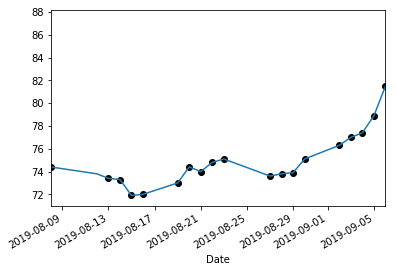

In [51]:
C['Close'][40:60].plot()
plt.scatter(buy.index,buy.values,color='red',marker="^")
plt.scatter(sell.index,sell.values,color='black')

# 合併

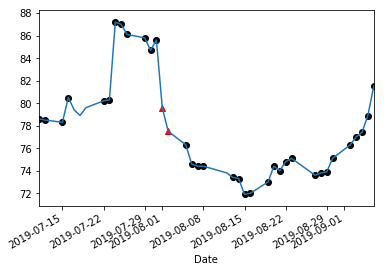

In [52]:
C['Close'][20:60].plot()
plt.scatter(buy.index,buy.values,color='red',marker="^")
plt.scatter(sell.index,sell.values,color='black')

# 平滑版本

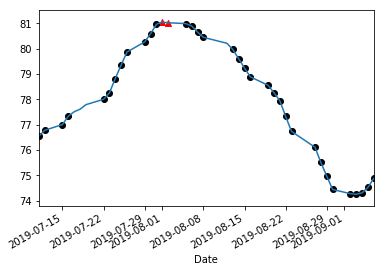

In [53]:
C_roll20 = pd.DataFrame(index=C.index)#空的dataframe index = 倒數60天股票日期
C_roll20['Close'] = C['Close'].rolling(20).mean()#收盤價做20天平滑
C_roll20['SIGNAL'] = C['SIGNAL']
buy = C_roll20[C_roll20['SIGNAL']==1]['Close']#買點
sell= C_roll20[C_roll20['SIGNAL']==2]['Close']#賣點
C_roll20['Close'][20:].plot()
plt.scatter(buy.index,buy.values,color='red',marker="^")
plt.scatter(sell.index,sell.values,color='black')